# k-NN 학습 알고리듬의 구현

* 데이터 불러오기
* Minkowski 거리 정의를 이용한 k-NN 학습 알고리듬의 구현

: 선형 탐색을 지원하는 테이블 구조에서는 O(n)의 시간 복잡도를 가짐

* kD Tree나 Ball Tree를 훈련 데이터의 저장과 탐색에 이용하기

kD Tree의 원리 및 구조
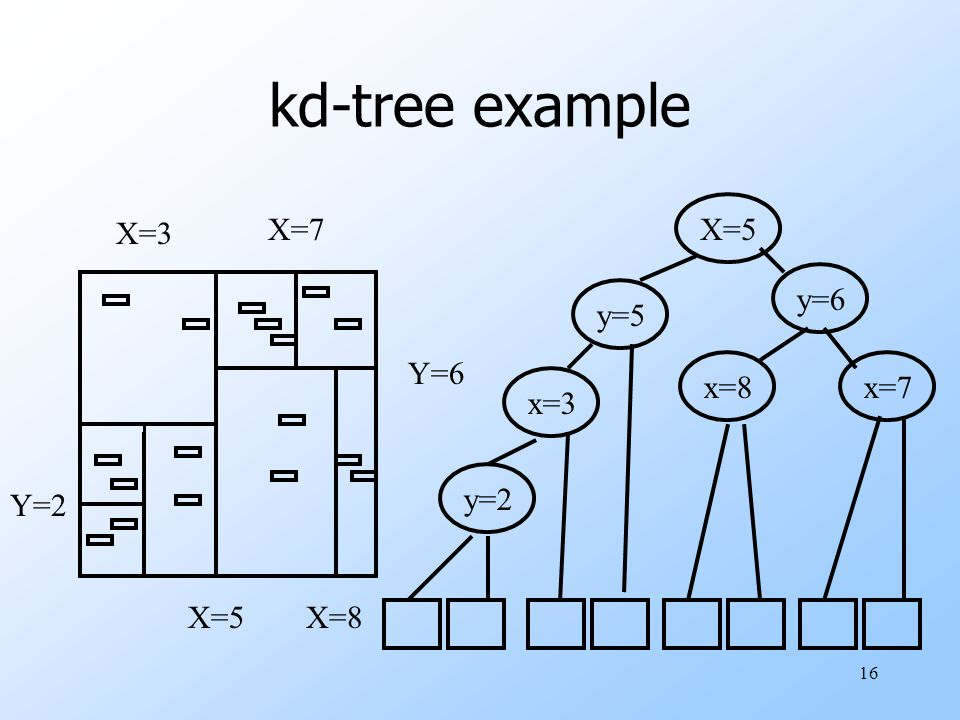

Ball Tree의 원리 및 구조
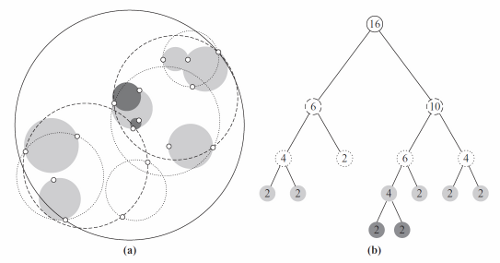

* kD Tree를 구현하여 k-NN 이용하기

* Locality Sensiive Hashing을 구현하여 k-NN 적용하기
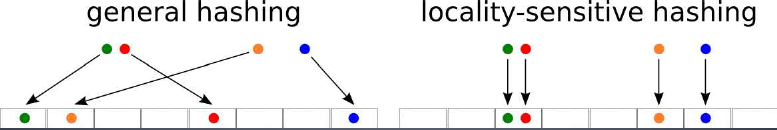

In [1]:
## 데이터 준비

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# tensorflow dataset에서 MNIST 데이터 가져오기
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)
''''
# Wine Quality 데이터셋 로드
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=';')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
n_lables = len(np.unique(y))
print(f"목표 변수의 갯수: {n_lables}")
print(f"목표 변수: {np.unique(y)}")

# 데이터를 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 크기: {X_train.shape}")
print(f"학습 데이터의 목표 변수 갯수: {y_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")
print(f"테스트 데이터의 목표 변수 갯수: {y_test.shape}")
'''


(60000, 28, 28)
(10000, 28, 28)


'\'\n# Wine Quality 데이터셋 로드\nurl = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"\ndata = pd.read_csv(url, delimiter=\';\')\n\nX = data.iloc[:, :-1].values\ny = data.iloc[:, -1].values\nn_lables = len(np.unique(y))\nprint(f"목표 변수의 갯수: {n_lables}")\nprint(f"목표 변수: {np.unique(y)}")\n\n# 데이터를 학습용과 테스트용으로 분리\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nprint(f"학습 데이터 크기: {X_train.shape}")\nprint(f"학습 데이터의 목표 변수 갯수: {y_train.shape}")\nprint(f"테스트 데이터 크기: {X_test.shape}")\nprint(f"테스트 데이터의 목표 변수 갯수: {y_test.shape}")\n'

In [2]:
## k-NN 모델 구현
from collections import Counter

def minkowski_distance(x1, x2, q):
    return np.sum(np.abs(x1 - x2) ** q) ** (1 / q)

class KNN:
    def __init__(self, k=3, q=2):
        self.k = k
        self.q = q

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):     # Wrapper 함수
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # 거리 계산
        distances = [minkowski_distance(x, x_train, self.q) for x_train in self.X_train]
        # 가장 가까운 k개의 샘플 선택
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # 가장 흔한 클래스 반환
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

for i in range(10):
    for j in range(3):
        # k-NN 모델 초기화 및 학습
        k = 2 * i + 1
        q = j + 1  # 유클리드 거리
        knn = KNN(k=k, q=q)
        knn.fit(X_train, y_train)

        # 테스트 데이터 예측
        y_pred = knn.predict(X_test)

        # 모델 정확도 계산
        accuracy = np.sum(y_pred == y_test) / len(y_test)
        print(f"k-NN 분류기의 정확도 (k={k}, q={q}): {accuracy:.2f}")


KeyboardInterrupt: 

In [5]:
## scikit-learn의 k-NN 이용하기 (kD Tree 이용)

from sklearn.neighbors import NearestNeighbors

# X_train, y_train의 개별 example을 1차원으로 평탄화 하기
X_train = X_train[:, -1]
X_test = X_test[:, -1]


# KD-Tree를 사용한 k-NN
k = 3
nn = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
nn.fit(X_train)

distances, indices = nn.kneighbors(X_test)
y_pred = np.array([Counter(y_train[indices[i]]).most_common(1)[0][0] for i in range(len(indices))])

# 모델 정확도 계산
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"KD-Tree를 사용한 k-NN 분류기의 정확도: {accuracy:.2f}")


ValueError: Expected 2D array, got 1D array instead:
array=[0 0 0 ... 0 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
## kD Tree 직접 구현하기

import numpy as np
from heapq import heappush, heappop

class Node:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    if len(points) == 0:
        return None

    k = len(points[0])  # assumes all points have the same dimension
    axis = depth % k

    points.sort(key=lambda x: x[axis])
    median = len(points) // 2

    return Node(
        point=points[median],
        left=build_kdtree(points[:median], depth + 1),
        right=build_kdtree(points[median + 1:], depth + 1)
    )

# KD-Tree 구축
X_train_list = X_train.tolist()
kd_tree = build_kdtree(X_train_list)

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((np.array(x1) - np.array(x2)) ** 2))

def k_nearest_neighbors(root, point, k, depth=0):
    if root is None:
        return []

    k_neighbors = []
    k = len(root.point)
    axis = depth % k

    next_branch = None
    opposite_branch = None
    if point[axis] < root.point[axis]:
        next_branch = root.left
        opposite_branch = root.right
    else:
        next_branch = root.right
        opposite_branch = root.left

    k_neighbors = k_nearest_neighbors(next_branch, point, k, depth + 1)

    distance = euclidean_distance(point, root.point)
    heappush(k_neighbors, (-distance, root.point))
    if len(k_neighbors) > k:
        heappop(k_neighbors)

    if len(k_neighbors) < k or abs(point[axis] - root.point[axis]) < -k_neighbors[0][0]:
        k_neighbors += k_nearest_neighbors(opposite_branch, point, k, depth + 1)
        k_neighbors = sorted(k_neighbors, key=lambda x: x[0], reverse=True)[:k]

    return k_neighbors

def predict(kd_tree, X_test, k):
    y_pred = []
    for point in X_test:
        neighbors = k_nearest_neighbors(kd_tree, point.tolist(), k)
        labels = [y_train[X_train.tolist().index(neighbor[1])] for neighbor in neighbors]
        most_common = Counter(labels).most_common(1)[0][0]
        y_pred.append(most_common)
    return np.array(y_pred)

# 테스트 데이터 예측
k = 3
y_pred = predict(kd_tree, X_test, k)

# 모델 정확도 계산
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"KD-Tree를 사용한 k-NN 분류기의 정확도: {accuracy:.2f}")


KD-Tree를 사용한 k-NN 분류기의 정확도: 0.47


In [6]:
## Locality Sensitive Hashing을 이용한 k-NN의 구현

import numpy as np
from collections import defaultdict
from sklearn.metrics import pairwise_distances_argmin_min

class LSH:
    def __init__(self, input_dim, num_hash_tables, hash_size):
        self.input_dim = input_dim
        self.num_hash_tables = num_hash_tables
        self.hash_size = hash_size
        self.hash_tables = [defaultdict(list) for _ in range(num_hash_tables)]
        self.hash_functions = [np.random.randn(hash_size, input_dim) for _ in range(num_hash_tables)]

    def _hash(self, hash_function, x):
        return tuple((np.dot(hash_function, x) > 0).astype(int))

    def fit(self, X):
        for i, x in enumerate(X):
            for table, hash_function in zip(self.hash_tables, self.hash_functions):
                hash_value = self._hash(hash_function, x)
                table[hash_value].append(i)

    def query(self, x, num_neighbors):
        candidates = set()
        for table, hash_function in zip(self.hash_tables, self.hash_functions):
            hash_value = self._hash(hash_function, x)
            candidates.update(table[hash_value])

        candidates = list(candidates)
        if not candidates:
            return []

        candidates = np.array(candidates)
        closest_indices, _ = pairwise_distances_argmin_min([x], X_train[candidates])
        return candidates[closest_indices][:num_neighbors]

# LSH 모델 초기화 및 학습
num_hash_tables = 5
hash_size = 11
lsh = LSH(input_dim=X_train.shape[1], num_hash_tables=num_hash_tables, hash_size=hash_size)
lsh.fit(X_train)

def predict(lsh, X_test, k):
    y_pred = []
    for x in X_test:
        neighbors = lsh.query(x, k)
        if len(neighbors) == 0:
            y_pred.append(np.random.choice(y_train))  # No neighbors found, random prediction
        else:
            neighbor_labels = y_train[neighbors]
            most_common = Counter(neighbor_labels).most_common(1)[0][0]
            y_pred.append(most_common)
    return np.array(y_pred)

# 테스트 데이터 예측
k = 3
y_pred = predict(lsh, X_test, k)

# 모델 정확도 계산
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"LSH를 사용한 k-NN 분류기의 정확도: {accuracy:.2f}")


IndexError: tuple index out of range

# k-Means 학습 알고리듬의 구현

* 데이터 불러오기
* 라이브러리 함수를 이용한 k-Means의 수행
* 학습 결과 시각화
* 클러스터 성능 평가

In [23]:
## 데이터 불러오기
%reset -f

import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# 데이터셋 로드 및 전처리
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

print(f"학습 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")

k = 10

학습 데이터 크기: (60000, 784)
테스트 데이터 크기: (10000, 784)


In [25]:
## 라이브러리 함수를 이용한 k-Means 알고리듬의 구현

from sklearn.cluster import KMeans

# k-Means 클러스터링 적용
kmeans = KMeans(n_clusters=k, max_iter=1000, tol=1e-5, random_state=42)
kmeans.fit(X_train)

# 클러스터 레이블 예측
y_train_pred = kmeans.predict(X_train)
y_test_pred = kmeans.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [26]:
## k-Means 알고리듬의 실제 구현

# 데이터 샘플링
sample_size = 1000
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sample = X_train[indices]
y_sample = y_train[indices]

# k-Means 알고리즘 구현
class KMeans:
    def __init__(self, k=10, max_iters=100, tol=1e-7):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        for i in range(self.max_iters):
            self.labels = self._assign_labels(X)
            new_centroids = self._compute_centroids(X)
            if np.all(np.linalg.norm(self.centroids - new_centroids, axis=1) < self.tol):
                break
            self.centroids = new_centroids

    def _assign_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X):
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            if len(X[self.labels == i]) == 0:
                continue
            centroids[i] = X[self.labels == i].mean(axis=0)
        return centroids

    def predict(self, X):
        return self._assign_labels(X)

# 첫 번째 k-Means 클러스터링 적용
k = 10
max_iters = int(1e2)
kmeans1 = KMeans(k=k, max_iters=max_iters)
kmeans1.fit(X_sample)
y_sample_pred1 = kmeans1.predict(X_sample)


In [27]:
## 지도학습의 레이블과 비교한 분류성능 (정확도) 평가

# 클러스터 레이블과 실제 레이블 매핑
def find_label_mapping(y_true, y_pred, k):
    cost_matrix = np.zeros((k, k), dtype=int)
    for i in range(k):
        for j in range(k):
            cost_matrix[i, j] = np.sum((y_true == i) & (y_pred == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    return row_ind, col_ind

row_ind1, col_ind1 = find_label_mapping(y_sample, y_sample_pred1, k)
label_mapping1 = dict(zip(col_ind1, row_ind1))
y_sample_pred1_mapped = np.array([label_mapping1[label] for label in y_sample_pred1])

# 분류 정확도 계산
train_accuracy = accuracy_score(y_sample, y_sample_pred1_mapped)
print(f"Train 데이터의 분류 정확도: {train_accuracy:.2f}")


Train 데이터의 분류 정확도: 0.50


In [28]:
## 분류 (Clustering) 성능 평가
'''
from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
silhouette_avg = silhouette_score(X_train, y_train_pred)
print(f"Train 데이터의 실루엣 점수: {silhouette_avg:.2f}")

silhouette_avg_test = silhouette_score(X_test, y_test_pred)
print(f"Test 데이터의 실루엣 점수: {silhouette_avg_test:.2f}")
'''

'\nfrom sklearn.metrics import silhouette_score\n\n# 실루엣 점수 계산\nsilhouette_avg = silhouette_score(X_train, y_train_pred)\nprint(f"Train 데이터의 실루엣 점수: {silhouette_avg:.2f}")\n\nsilhouette_avg_test = silhouette_score(X_test, y_test_pred)\nprint(f"Test 데이터의 실루엣 점수: {silhouette_avg_test:.2f}")\n'

In [31]:
## 계층적 클러스터링: 앞의 클러스터링 결과물을 이용하여 재차 클러스터링을 수행

# 두 번째 k-Means 클러스터링 적용 (클러스터 내부에서 추가 클러스터링)
kmeans2 = KMeans(k=k, max_iters=max_iters)
for i in range(k):
    cluster_indices = np.where(y_sample_pred1_mapped == i)[0]
    if len(cluster_indices) > 0:
        kmeans2.fit(X_sample[cluster_indices])
        y_sample_pred2 = kmeans2.predict(X_sample[cluster_indices])
        row_ind2, col_ind2 = find_label_mapping(y_sample[cluster_indices], y_sample_pred2, k)
        label_mapping2 = dict(zip(col_ind2, row_ind2))
        y_sample_pred2_mapped = np.array([label_mapping2[label] for label in y_sample_pred2])
        y_sample_pred1_mapped[cluster_indices] = y_sample_pred2_mapped

# 분류 정확도 계산
train_accuracy = accuracy_score(y_sample, y_sample_pred1_mapped)
print(f"Train 데이터의 분류 정확도: {train_accuracy:.2f}")

# 테스트 데이터에 대한 예측 및 정확도 계산
y_test_pred1 = kmeans2.predict(X_test)
y_test_pred1_mapped = np.array([label_mapping1[label] for label in y_test_pred1])
test_accuracy = accuracy_score(y_test, y_test_pred1_mapped)
print(f"Test 데이터의 분류 정확도: {test_accuracy:.2f}")


Train 데이터의 분류 정확도: 0.43
Test 데이터의 분류 정확도: 0.12


In [32]:
## 3차 클러스터링 수행

# 세 번째 k-Means 클러스터링 적용
kmeans3 = KMeans(k=k, max_iters=max_iters)
for i in range(k):
    cluster_indices = np.where(y_sample_pred1_mapped == i)[0]
    if len(cluster_indices) > 0:
        kmeans3.fit(X_sample[cluster_indices])
        y_sample_pred3 = kmeans3.predict(X_sample[cluster_indices])
        row_ind3, col_ind3 = find_label_mapping(y_sample[cluster_indices], y_sample_pred3, k)
        label_mapping3 = dict(zip(col_ind3, row_ind3))
        y_sample_pred3_mapped = np.array([label_mapping3[label] for label in y_sample_pred3])
        y_sample_pred1_mapped[cluster_indices] = y_sample_pred3_mapped

# 분류 정확도 계산
train_accuracy_third = accuracy_score(y_sample, y_sample_pred1_mapped)
print(f"Train 데이터의 분류 정확도 (세 번째 클러스터링): {train_accuracy_third:.2f}")

# 테스트 데이터에 대한 예측 및 정확도 계산
y_test_pred1 = kmeans3.predict(X_test)
y_test_pred1_mapped = np.array([label_mapping1[label] for label in y_test_pred1])
test_accuracy = accuracy_score(y_test, y_test_pred1_mapped)
print(f"Test 데이터의 분류 정확도 (첫 번째 클러스터링): {test_accuracy:.2f}")


Train 데이터의 분류 정확도 (세 번째 클러스터링): 0.46
Test 데이터의 분류 정확도 (첫 번째 클러스터링): 0.07


In [ ]:
## Linkage Function을 이용한 클러스터링 알고리듬의 개선

class KMeansWithLinkage:
    def __init__(self, k=10, max_iters=100, tol=1e-4, linkage='single'):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.linkage = linkage

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        for i in range(self.max_iters):
            self.labels = self._assign_labels(X)
            new_centroids = self._compute_centroids(X)
            if np.all(np.linalg.norm(self.centroids - new_centroids, axis=1) < self.tol):
                break
            self.centroids = new_centroids

    def _assign_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X):
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            if len(X[self.labels == i]) == 0:
                continue
            centroids[i] = X[self.labels == i].mean(axis=0)
        return centroids

    def _linkage_distance(self, A, B):
        if self.linkage == 'single':
            return np.min([np.linalg.norm(x - y) for x in A for y in B])
        elif self.linkage == 'complete':
            return np.max([np.linalg.norm(x - y) for x in A for y in B])
        elif self.linkage == 'average':
            return np.mean([np.linalg.norm(x - y) for x in A for y in B])
        elif self.linkage == 'centroid':
            centroid_A = np.mean(A, axis=0)
            centroid_B = np.mean(B, axis=0)
            return np.linalg.norm(centroid_A - centroid_B)
        else:
            raise ValueError(f"Unknown linkage type: {self.linkage}")

    def predict(self, X):
        return self._assign_labels(X)

# k-Means 클러스터링 적용
k = 6
linkage = 'centroid'
kmeans1 = KMeansWithLinkage(k=k, max_iters=100, linkage=linkage)
kmeans1.fit(X_sample)
y_sample_pred1 = kmeans1.predict(X_sample)

# 클러스터 레이블과 실제 레이블 매핑
def find_label_mapping(y_true, y_pred, k):
    cost_matrix = np.zeros((k, k), dtype=int)
    for i in range(k):
        for j in range(k):
            cost_matrix[i, j] = np.sum((y_true == i) & (y_pred == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    return row_ind, col_ind

row_ind1, col_ind1 = find_label_mapping(y_sample, y_sample_pred1, k)
label_mapping1 = dict(zip(col_ind1, row_ind1))
y_sample_pred1_mapped = np.array([label_mapping1[label] for label in y_sample_pred1])

# 분류 정확도 계산
train_accuracy = accuracy_score(y_sample, y_sample_pred1_mapped)
print(f"Train 데이터의 분류 정확도 (첫 번째 클러스터링): {train_accuracy:.2f}")

# 두 번째 k-Means 클러스터링 적용
kmeans2 = KMeansWithLinkage(k=k, max_iters=100, linkage=linkage)
for i in range(k):
    cluster_indices = np.where(y_sample_pred1_mapped == i)[0]
    if len(cluster_indices) > 0:
        kmeans2.fit(X_sample[cluster_indices])
        y_sample_pred2 = kmeans2.predict(X_sample[cluster_indices])
        row_ind2, col_ind2 = find_label_mapping(y_sample[cluster_indices], y_sample_pred2, k)
        label_mapping2 = dict(zip(col_ind2, row_ind2))
        y_sample_pred2_mapped = np.array([label_mapping2[label] for label in y_sample_pred2])
        y_sample_pred1_mapped[cluster_indices] = y_sample_pred2_mapped

# 분류 정확도 계산
train_accuracy_second = accuracy_score(y_sample, y_sample_pred1_mapped)
print(f"Train 데이터의 분류 정확도 (두 번째 클러스터링): {train_accuracy_second:.2f}")

# 세 번째 k-Means 클러스터링 적용
kmeans3 = KMeansWithLinkage(k=k, max_iters=100, linkage=linkage)
for i in range(k):
    cluster_indices = np.where(y_sample_pred1_mapped == i)[0]
    if len(cluster_indices) > 0:
        kmeans3.fit(X_sample[cluster_indices])
        y_sample_pred3 = kmeans3.predict(X_sample[cluster_indices])
        row_ind3, col_ind3 = find_label_mapping(y_sample[cluster_indices], y_sample_pred3, k)
        label_mapping3 = dict(zip(col_ind3, row_ind3))
        y_sample_pred3_mapped = np.array([label_mapping3[label] for label in y_sample_pred3])
        y_sample_pred1_mapped[cluster_indices] = y_sample_pred3_mapped

# 분류 정확도 계산
train_accuracy_third = accuracy_score(y_sample, y_sample_pred1_mapped)
print(f"Train 데이터의 분류 정확도 (세 번째 클러스터링): {train_accuracy_third:.2f}")

# 테스트 데이터에 대한 예측 및 정확도 계산
y_test_pred1 = kmeans1.predict(X_test)
y_test_pred1_mapped = np.array([label_mapping1[label] for label in y_test_pred1])
test_accuracy = accuracy_score(y_test, y_test_pred1_mapped)
print(f"Test 데이터의 분류 정확도 (첫 번째 클러스터링): {test_accuracy:.2f}")


/home/tf_env/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-22 10:57:25.854998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 10:57:26.015415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 10:57:26.015571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 10:57:26.024033: I te

KeyboardInterrupt: 

# FCM (Fuzzy C-Means Clustering)

In [ ]:
## 데이터 불러오기
%reset -f

import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# 데이터셋 로드 및 전처리
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

print(f"학습 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")


학습 데이터 크기: (60000, 784)
테스트 데이터 크기: (10000, 784)


In [ ]:
# 데이터 샘플링
sample_size = 1000
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sample = X_train[indices]
y_sample = y_train[indices]

print(f"샘플 데이터 크기: {X_sample.shape}")

샘플 데이터 크기: (1000, 784)


In [ ]:
!pip install scikit-fuzzy
import skfuzzy as fuzz

# Fuzzy C-Means 클러스터링 적용
n_clusters = 5
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_sample.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

# 클러스터 할당
cluster_labels = np.argmax(u, axis=0)

print(u)

[[0.20749377 0.14030426 0.14102288 ... 0.23532413 0.18273667 0.19316769]
 [0.21744059 0.16237095 0.16656146 ... 0.23284432 0.211406   0.21566736]
 [0.17191594 0.28405854 0.27256163 ... 0.14030405 0.18951858 0.17988157]
 [0.18572549 0.25099583 0.25340984 ... 0.15862771 0.20503253 0.19568407]
 [0.2174242  0.16227041 0.16644418 ... 0.2328998  0.21130621 0.21559931]]


In [ ]:
print(u[:, 4])

[0.208567   0.22088147 0.16704758 0.18264381 0.22086015]


# k-Means와 FCM의 차이 시각화


In [15]:
import numpy as np
import plotly.express as px
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Iris 데이터셋 로드
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA를 사용하여 3차원으로 변환
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"원본 데이터 형태: {X.shape}")
print(f"PCA 변환 후 데이터 형태: {X_pca.shape}")


원본 데이터 형태: (150, 4)
PCA 변환 후 데이터 형태: (150, 3)


In [16]:
# 데이터 시각화
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=y,
    title='3D Iris Data with PCA',
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
)
fig.show()


In [17]:
from sklearn.cluster import KMeans

# k-Means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)
kmeans_labels = kmeans.predict(X_pca)

# 클러스터링 결과 시각화
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=kmeans_labels,
    title='k-Means Clustering',
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
)
fig.add_scatter3d(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    z=kmeans.cluster_centers_[:, 2],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Cluster Centers'
)
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [18]:
!pip install plotly.graph_objects
import plotly.graph_objects as go


# 3. k-Means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)
kmeans_labels = kmeans.predict(X_pca)

# 클러스터 색상 정의 (R, G, B)
kmeans_colors = np.array([
    [255, 0, 0],  # Red
    [0, 255, 0],  # Green
    [0, 0, 255]   # Blue
])

# 각 데이터 포인트의 색상 할당
kmeans_point_colors = kmeans_colors[kmeans_labels]

# k-Means 클러스터링 결과 시각화
fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(size=3, color=['rgb({},{},{})'.format(r, g, b) for r, g, b in kmeans_point_colors])
)])

# 클러스터 중심 시각화
fig.add_trace(go.Scatter3d(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    z=kmeans.cluster_centers_[:, 2],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Cluster Centers'
))

fig.update_layout(title='k-Means Clustering with RGB Colors',
                  scene=dict(xaxis_title='PCA Component 1',
                             yaxis_title='PCA Component 2',
                             zaxis_title='PCA Component 3'))

fig.show()


ERROR: Could not find a version that satisfies the requirement plotly.graph_objects (from versions: none)
ERROR: No matching distribution found for plotly.graph_objects


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [20]:
!pip install scikit-fuzzy
import skfuzzy as fuzz

# Fuzzy C-Means 클러스터링
n_clusters = 3
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_pca.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

# 클러스터 할당
fcm_labels = np.argmax(u, axis=0)

# 클러스터링 결과 시각화
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=fcm_labels,
    title='Fuzzy C-Means Clustering',
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
)
fig.add_scatter3d(
    x=cntr[:, 0],
    y=cntr[:, 1],
    z=cntr[:, 2],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Cluster Centers'
)
fig.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=fdc45f7779eb24cf4a56b0f802a7a20b3b444f6da04bc1b0bc5aea2008fc3519
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [21]:
!pip install plotly.graph_objects
import plotly.graph_objects as go

# Fuzzy C-Means 클러스터링
n_clusters = 3
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_pca.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

# 클러스터 할당
fcm_labels = np.argmax(u, axis=0)

# 클러스터 색상 정의 (R, G, B)
cluster_colors = np.array([
    [1, 0, 0],  # Red
    [0, 1, 0],  # Green
    [0, 0, 1]   # Blue
])

# 각 데이터 포인트의 색상 계산
colors = np.dot(u.T, cluster_colors)

# Fuzzy C-Means 클러스터링 결과 시각화
fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(size=3, color=['rgb({},{},{})'.format(r, g, b) for r, g, b in colors]),
    text=['Cluster {}: {:.2f}, {:.2f}, {:.2f}'.format(fcm_labels[i], u[0, i], u[1, i], u[2, i]) for i in range(len(fcm_labels))]
)])

# 클러스터 중심 시각화
fig.add_trace(go.Scatter3d(
    x=cntr[:, 0],
    y=cntr[:, 1],
    z=cntr[:, 2],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Cluster Centers'
))

fig.update_layout(title='Fuzzy C-Means Clustering with RGB Color Mixing',
                  scene=dict(xaxis_title='PCA Component 1',
                             yaxis_title='PCA Component 2',
                             zaxis_title='PCA Component 3'))

fig.show()


ERROR: Could not find a version that satisfies the requirement plotly.graph_objects (from versions: none)
ERROR: No matching distribution found for plotly.graph_objects
